<center><u><H1>Reconhecimento de letra cursiva com TensorFlow</H1></u></center>

In [1]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data/', one_hot=True)

In [3]:
print("- Size:Training-set:\t\t{}".format(len(data.train.labels)))
print("- Size:Test-set:\t\t{}".format(len(data.test.labels)))
print("- Size:Validation-set:\t{}".format(len(data.validation.labels)))

- Size:Training-set:		55000
- Size:Test-set:		10000
- Size:Validation-set:	5000


In [4]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

## Function for plotting images

In [7]:
def plot_img(images, cls_label, cls_pred=None):
    
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            label = "True: {0}".format(cls_label[idx]) # shows only the class label
        else:
            label = "True: {0}, Pred: {1}".format(cls_label[idx], cls_pred[idx])

        ax.set_xlabel(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

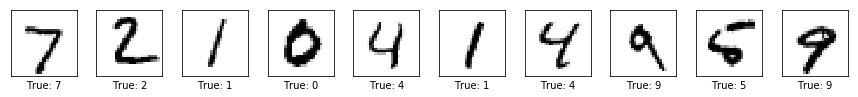

In [8]:
images = data.test.images[0:10]
cls_true = data.test.cls[0:10]
plot_img(images=images, cls_label=cls_true)

## Placeholder variables

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [15]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [16]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [17]:
y_true_cls = tf.argmax(y_true, axis=1)

## CNN configuration

In [19]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16        

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36        

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [20]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [21]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Creating a new Convolutional Layer

In [22]:
def conv_layer(input,              # The previous layer.
                num_input_channels, # Num. channels in prev. layer.
                filter_size,        # Width and height of each filter.
                num_filters,        # Number of filters.
                   ):

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)

    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME',
                         use_cudnn_on_gpu=True)

    layer += biases

    layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

## Flattening a layer

In [23]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

## Creating a new Fully-Connected Layer

In [24]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Filling the layers

In [25]:
## convolutional Layer1
layer_conv1, weights_conv1 = conv_layer(input=x_image,
                           num_input_channels=num_channels,
                           filter_size=filter_size1,
                           num_filters=num_filters1,
                           )

In [26]:
layer_conv1
#(?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?)

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [27]:
layer_conv2, weights_conv2 = conv_layer(input=layer_conv1,
                           num_input_channels=num_filters1,
                           filter_size=filter_size2,
                           num_filters=num_filters2,
                           )

In [28]:
layer_conv2
#The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images.

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [29]:
#Flatten layer:
layer_flat, num_features = flatten_layer(layer_conv2)

In [30]:
layer_flat

<tf.Tensor 'Reshape_2:0' shape=(?, 1764) dtype=float32>

In [31]:
num_features

1764

In [32]:
#Fully-Connected Layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [33]:
#shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [34]:
#Fully-Connected Layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [35]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [36]:
#Predicted Class
y_pred = tf.nn.softmax(layer_fc2)

In [37]:
#The class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, axis=1)

## Cost-function to be optimized

In [38]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)

In [39]:
cost = tf.reduce_mean(cross_entropy)

## Optimization Method

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance Metrics

In [41]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [42]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [43]:
#For GPU:
init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

In [44]:
train_batch_size = 64

In [45]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations

    for i in range(total_iterations, total_iterations + num_iterations):

        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        sess.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations

In [46]:
def plot_example_errors(cls_pred, correct):

    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = data.test.cls[incorrect]
    
    plot_img(images=images[0:10],
                cls_label=cls_true[0:10],
                cls_pred=cls_pred[0:10])

In [47]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [48]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.test.cls


    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization 

In [49]:
print_test_accuracy()

Accuracy on Test-Set: 15.8% (1579 / 10000)


## Performance after 10 optimization iterations

In [50]:
optimize(num_iterations=10)

Optimization Iteration:      1, Training Accuracy:  20.3%


In [51]:
print_test_accuracy()

Accuracy on Test-Set: 17.1% (1711 / 10000)


## Performance after 1000 optimization iterations

In [52]:
optimize(num_iterations=990)

Optimization Iteration:    101, Training Accuracy:  64.1%
Optimization Iteration:    201, Training Accuracy:  84.4%
Optimization Iteration:    301, Training Accuracy:  84.4%
Optimization Iteration:    401, Training Accuracy:  92.2%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  96.9%


Accuracy on Test-Set: 97.3% (9734 / 10000)
Example errors:


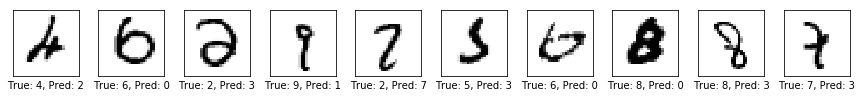

In [55]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

optimize(num_iterations=9000)

In [ ]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Visualization of Weights and Layers

In [50]:
def plot_conv_weights(weights, input_channel=0):
    w = sess.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])    
    plt.show()

In [51]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}

    values = sess.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])    
    plt.show()

## Plotting weights, Convolutional Layers

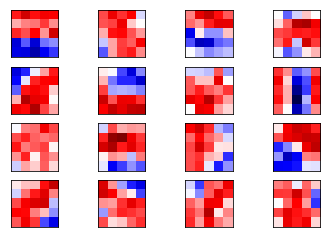

In [52]:
plot_conv_weights(weights=weights_conv1)

In [53]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

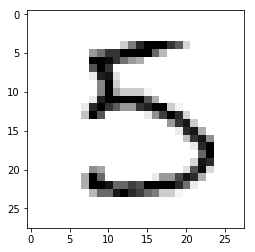

In [54]:
image1 = data.test.images[15]
plot_image(image1)

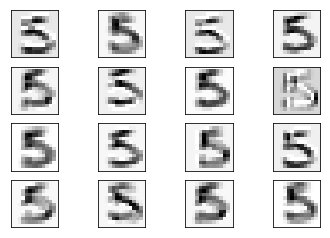

In [55]:
plot_conv_layer(layer=layer_conv1, image=image1)

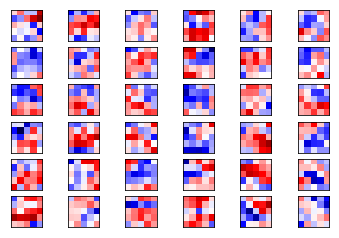

In [56]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

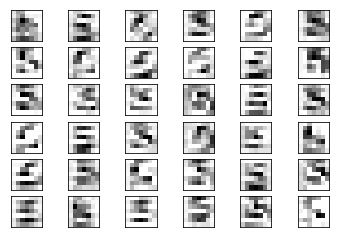

In [57]:
plot_conv_layer(layer=layer_conv2, image=image1)

In [ ]:
# sess.close()

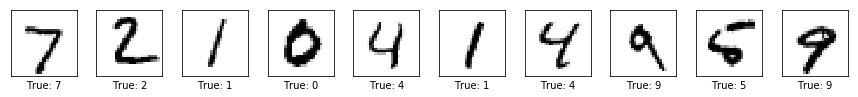

In [66]:
images = data.test.images[0:10]

cls_true = data.test.cls[0:10]

plot_img(images=images, cls_label=cls_true)

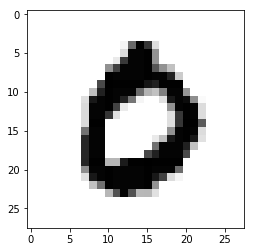

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [81]:
i = 3
teste=data.test.images[i]
teste_cls = data.test.cls[i]
plot_image(teste)

print(data.test.labels[i])

In [58]:
i = 0
j = 9

images = data.test.images[i:j, :]

labels = data.test.labels[i:j, :]

seade_dict = {x: images,
             y_true: labels}

print( sess.run(y_pred_cls, feed_dict=seade_dict) )

[7 2 1 0 4 1 4 9 5]


In [62]:
import cv2

# Função para carregar imagens do SEADE
def load_user_image(filepath):
    # Jogando imagem na memória
    img0_v1 = cv2.imread(filepath, 0)
    # Invertendo as cores
    img0_v1 = cv2.resize(255-img0_v1, (28, 28))
    # Retornando um array flat, tornando matrix 28x28 um array de 784 posições 
    return img0_v1.flatten() / 255.0

In [89]:
# Carregando imagens do SEADE
seade_images = np.array([
    load_user_image("seade_data/v1/0.png"),
    load_user_image("seade_data/v1/1.png"),
    load_user_image("seade_data/v1/2.png"),
    load_user_image("seade_data/v1/3.png"),
    load_user_image("seade_data/v1/4.png"),
    load_user_image("seade_data/v1/5.png"),
    load_user_image("seade_data/v1/6.png"),
    load_user_image("seade_data/v1/7.png"),
    load_user_image("seade_data/v1/8.png"),
    load_user_image("seade_data/v1/9.png")
])

print(seade_images.shape)

(10, 784)


In [93]:
seade_correct_vals = np.zeros((10,10))
i = 0

for no in [0,1,2,3,4,5,6,7,8,9]:
    correct_val = np.zeros((10))
    correct_val[no] = 1
    seade_correct_vals[i] = correct_val
    i += 1

seade_correct_vals.shape

(10, 10)

In [94]:
seade_dict = {x: seade_images, y_true: seade_correct_vals}

In [95]:
seade_prediction = sess.run(y_pred_cls, feed_dict=seade_dict) 
seade_prediction

array([0, 1, 2, 3, 6, 5, 6, 7, 7, 7])

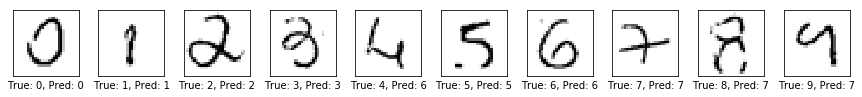

In [86]:
plot_img(images=seade_images,
                cls_label=[0,1,2,3,4,5,6,7,8,9],
                cls_pred=seade_prediction)

In [96]:
# Carga de imagens ruins
seade_images_v2 = np.array([
    load_user_image("seade_data/v2/0.png"),
    load_user_image("seade_data/v2/1.png"),
    load_user_image("seade_data/v2/2.png"),
    load_user_image("seade_data/v2/3.png"),
    load_user_image("seade_data/v2/4.png"),
    load_user_image("seade_data/v2/5.png"),
    load_user_image("seade_data/v2/6.png"),
    load_user_image("seade_data/v2/7.png"),
    load_user_image("seade_data/v2/8.png"),
    load_user_image("seade_data/v2/9.png")
])

In [97]:
seade_dict_v2 = {x: seade_images_v2, y_true: seade_correct_vals}

In [98]:
seade_prediction_v2 = sess.run(y_pred_cls, feed_dict=seade_dict_v2) 
seade_prediction_v2

array([0, 1, 2, 3, 6, 5, 6, 7, 8, 8])

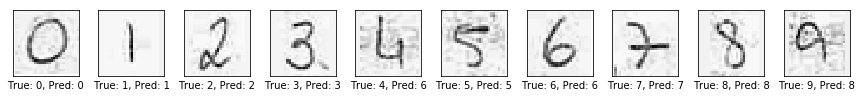

In [99]:
plot_img(images=seade_images_v2,
                cls_label=[0,1,2,3,4,5,6,7,8,9],
                cls_pred=seade_prediction_v2)

Melhorando as imagens através  na entrada através de remoção de ruído, intensificando os brancos e pretos

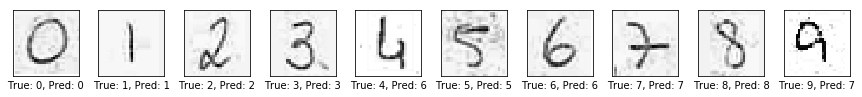

In [107]:
# Carga de imagens ruins
seade_images_v2_cleaned = np.array([
    load_user_image("seade_data/v2_cleaned/0.png"),
    load_user_image("seade_data/v2_cleaned/1.png"),
    load_user_image("seade_data/v2_cleaned/2.png"),
    load_user_image("seade_data/v2_cleaned/3.png"),
    load_user_image("seade_data/v2_cleaned/4.png"),
    load_user_image("seade_data/v2_cleaned/5.png"),
    load_user_image("seade_data/v2_cleaned/6.png"),
    load_user_image("seade_data/v2_cleaned/7.png"),
    load_user_image("seade_data/v2_cleaned/8.png"),
    load_user_image("seade_data/v2_cleaned/9.png")
])
seade_dict_v2_cleaned = {x: seade_images_v2_cleaned, y_true: seade_correct_vals}
seade_prediction_v2_cleaned = sess.run(y_pred_cls, feed_dict=seade_dict_v2_cleaned) 
plot_img(images=seade_images_v2_cleaned,
                cls_label=[0,1,2,3,4,5,6,7,8,9],
                cls_pred=seade_prediction_v2_cleaned)